In [3]:
import pandas as pd

In [4]:
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')

In [5]:
train.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-01-10,1453329.50,71.89,2.603,211.671989,7.838
1,1,2010-02-04,1594968.28,62.27,2.719,210.820450,7.808
2,1,2010-02-07,1492418.14,80.91,2.669,211.223533,7.787
3,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106
4,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106


In [5]:
test.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment
0,1,2012-10-19,67.97,3.594,223.425723,6.573
1,1,2012-10-26,69.16,3.506,223.444251,6.573
2,1,2012-11-05,73.77,3.688,221.725663,7.143
3,1,2012-12-10,62.99,3.601,223.381296,6.573
4,2,2012-10-19,68.08,3.594,223.059808,6.170


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6255 non-null   int64  
 1   Date          6255 non-null   object 
 2   Weekly_Sales  6255 non-null   float64
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   CPI           6255 non-null   float64
 6   Unemployment  6255 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 342.2+ KB


In [7]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [8]:
train['Weekly_Sales'].describe()

count    6.255000e+03
mean     1.047722e+06
std      5.654876e+05
min      2.099862e+05
25%      5.538695e+05
50%      9.609985e+05
75%      1.422573e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64

In [9]:
date_to_weekly_sales = train.groupby('Date')['Weekly_Sales'].mean()
date_to_weekly_sales

Date
2010-01-10    9.386639e+05
2010-02-04    1.120530e+06
2010-02-07    1.087055e+06
2010-02-19    1.072822e+06
2010-02-26    9.770794e+05
                  ...     
2012-09-14    9.828009e+05
2012-09-21    9.856566e+05
2012-09-28    9.718867e+05
2012-10-02    1.111320e+06
2012-10-08    1.053410e+06
Name: Weekly_Sales, Length: 139, dtype: float64

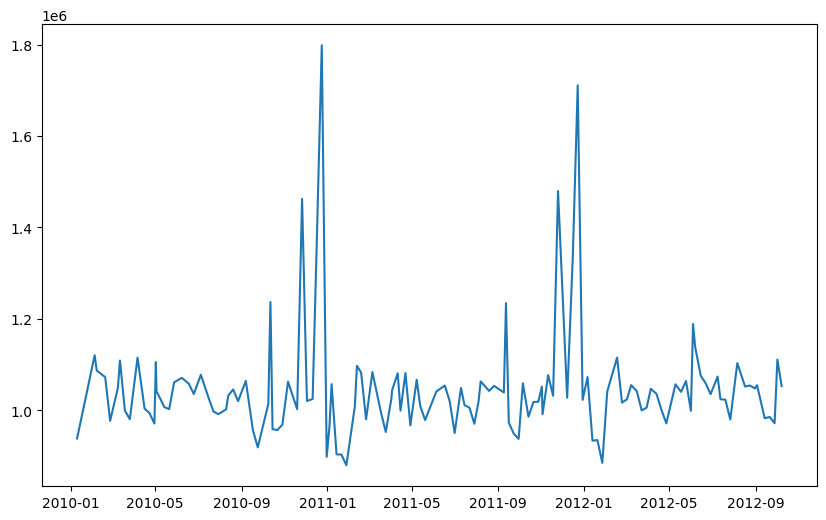

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(date_to_weekly_sales)
plt.show()

In [11]:
train['Month'] = train['Date'].dt.month
train['Week_Of_Year'] = train['Date'].dt.isocalendar().week
train['Day_Of_Week'] = train['Date'].dt.dayofweek
train['Is_Holiday'] = train['Date'].dt.month.isin([1, 7, 12]).astype(int)

In [13]:
import numpy as np
import statsmodels.api as sm

store_ids = train['Store'].unique()
predictions = []

for store_id in store_ids:
    store_data = train[train['Store'] == store_id].sort_values('Date')
    y = store_data['Weekly_Sales'].astype(float)
    X = store_data[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month',
                    'Week_Of_Year', 'Day_Of_Week', 'Is_Holiday']]

    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

    y = np.asarray(y, dtype=float)
    X = np.asarray(X, dtype=float)

    train_size = len(y) - 4
    y_train, X_train = y[:train_size], X[:train_size]
    X_test = X[train_size:]

    model = sm.tsa.statespace.SARIMAX(y_train, exog=X_train)
    model_fit = model.fit(disp=False)

    forecast = model_fit.predict(start=len(y_train), end=len(y_train) + 3, exog=X_test)
    predictions.extend(forecast.tolist())

In [14]:
data = {
    "source_attractiveness": predictions
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")